In [1]:
import pandas as pd
import pyspark as ps
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("Spark Session Intro") \
            .getOrCreate()
sc = spark.sparkContext

In [3]:
f_tweets_json = spark.read.json('../spark/french_tweets.json')

## Visualizing the Schema

Below we are able to visualize the schema of the french_tweets.json file. By investigating this we are able to determine what elements of data will be useful for our analysis. 

In [4]:
f_tweets_json.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

In [5]:
f_tweets_json.createOrReplaceTempView('tweets')

In [6]:
type(f_tweets_json)

pyspark.sql.dataframe.DataFrame

## Visualizing Screen Names that get the most Replies

Here we asked ourselves who is getting the most interaction from other Twitter users. We found that within this data set President Macron was receiving the most replies. Followed by a french television station and Marine Le Pen. These three will be the primary focus of our investigation going forward. 

In [8]:
spark.sql('drop view if exists top_screen_name;')
q2 = '''
create temp view top_screen_name as
select in_reply_to_screen_name, in_reply_to_user_id, count(distinct user.id) as reply_count
from tweets
where in_reply_to_screen_name is not null
group by 1, 2
order by 3 desc
limit 20;
'''
spark.sql(q2)
q3 = '''
select * from top_screen_name;
'''
spark.sql(q3).show()

+-----------------------+-------------------+-----------+
|in_reply_to_screen_name|in_reply_to_user_id|reply_count|
+-----------------------+-------------------+-----------+
|         EmmanuelMacron|         1976143068|        245|
|                   TPMP|          832766641|        173|
|           MLP_officiel|          217749896|        131|
|                  BFMTV|          133663801|        128|
|           Cyrilhanouna|          378632690|        102|
|           dupontaignan|           38170599|         99|
|              Qofficiel| 743432061088899073|         49|
|                 GG_RMC|          114512948|         47|
|               THEDAMSO|          529836126|         47|
|        Marion_M_Le_Pen|          520449734|         43|
|              jmaphatie|          369914677|         41|
|              Le_Figaro|            8350912|         39|
|                   libe|           68440549|         38|
|               leLab_E1|          376812938|         37|
|            J

In [10]:
#spark.sql('drop view top_acc_replies;')
q5 = '''
create temp view top_acc_replies as
select in_reply_to_screen_name, user.id, user.name, user.created_at as user_creation_date, created_at as tweet_date, id as tweet_id, place.name, place.country
from tweets
where in_reply_to_screen_name in (select in_reply_to_screen_name from top_screen_name)
order by 1 desc;
'''
spark.sql(q5)
replies = spark.sql('select * from top_acc_replies')
replies.show()

+-----------------------+------------------+--------------------+--------------------+--------------------+------------------+----------------+--------+
|in_reply_to_screen_name|                id|                name|  user_creation_date|          tweet_date|          tweet_id|            name| country|
+-----------------------+------------------+--------------------+--------------------+--------------------+------------------+----------------+--------+
|                   libe|         552846751|      nordine cherfi|Fri Apr 13 16:51:...|Thu Apr 27 08:31:...|857512427344326656|        Toulouse|  France|
|                   libe|         149142551|          Crab2 Crab|Fri May 28 14:35:...|Thu Apr 27 11:41:...|857560320306446336|           Meaux|  France|
|                   libe|        2354982361|    le sac de talent|Fri Feb 21 15:39:...|Thu Apr 27 11:09:...|857552160426426373|         Quévert|  France|
|                   libe|         168097124|               Petou|Sun Jul 18 11:07:

In [12]:
replies_df = replies.select("*").toPandas()

In [13]:
replies_df['user_creation_dt'] = replies_df['user_creation_date'].apply(lambda x:pd.to_datetime(x))
replies_df['tweet_dt'] = replies_df['tweet_date'].apply(lambda x:pd.to_datetime(x))

In [14]:
replies_df.columns = ['in_reply_to_screen_name','reply_user_id','reply_user_name', 'user_creation_date','tweet_date','tweet_id','location_name', 'country', 'user_creation_dt','tweet_dt']

## Creating a DataFrame containing all accounts that replied to the top 20 user names

We want to be able to find out some useful information about the account who are interacting with our top 20 user names, so we created a Pandas DataFrame so that we could visualize some of this information. 

In [15]:
replies_df.head()

,in_reply_to_screen_name,reply_user_id,reply_user_name,user_creation_date,tweet_date,tweet_id,location_name,country,user_creation_dt,tweet_dt
0,libe,493446569,CPasbien,Wed Feb 15 20:19:08 +0000 2012,Wed Apr 26 15:25:23 +0000 2017,857254286539067392,Niort,France,2012-02-15 20:19:08+00:00,2017-04-26 15:25:23+00:00
1,libe,579091759,Rêv de Presse,Sun May 13 16:29:36 +0000 2012,Wed Apr 26 17:33:11 +0000 2017,857286446939598850,Angers,France,2012-05-13 16:29:36+00:00,2017-04-26 17:33:11+00:00
2,libe,462343380,Cynthia-ZD,Thu Jan 12 21:17:40 +0000 2012,Thu Apr 27 07:01:47 +0000 2017,857489939549827074,Noisy-le-Grand,France,2012-01-12 21:17:40+00:00,2017-04-27 07:01:47+00:00
3,libe,493446569,CPasbien,Wed Feb 15 20:19:08 +0000 2012,Thu Apr 27 07:37:32 +0000 2017,857498936780705792,Niort,France,2012-02-15 20:19:08+00:00,2017-04-27 07:37:32+00:00
4,libe,493446569,CPasbien,Wed Feb 15 20:19:08 +0000 2012,Thu Apr 27 07:47:56 +0000 2017,857501554739466241,Niort,France,2012-02-15 20:19:08+00:00,2017-04-27 07:47:56+00:00


In [16]:
gb_name = replies_df.groupby('in_reply_to_screen_name')

## Reply Account Creation Date

We took a look at the dates in which the accounts replying to our top candidate were created. Our line of thinking here was to pinpoint any accounts that might be bots created to run propaganda surrounding the election. Below is the earliest and latest creation dates for accounts the relpied to our top candidates.

In [17]:
gb_name.agg({'user_creation_dt':[max, min], 'tweet_dt':[max, min]})

user_creation_dt                            \
                                              max                       min   
in_reply_to_screen_name                                                       
AudreyPulvar            2017-01-22 18:31:37+00:00 2008-01-04 15:59:27+00:00   
BFMTV                   2017-04-21 13:17:58+00:00 2009-06-29 05:32:38+00:00   
Cyrilhanouna            2017-04-27 20:05:23+00:00 2009-06-17 07:30:16+00:00   
EmmanuelMacron          2017-04-23 17:09:28+00:00 2009-01-06 19:43:19+00:00   
Europe1                 2017-02-07 04:37:46+00:00 2011-02-15 08:40:11+00:00   
GG_RMC                  2017-04-24 18:11:20+00:00 2009-04-08 18:25:22+00:00   
JJBourdin_RMC           2017-04-27 06:57:02+00:00 2010-06-27 18:54:35+00:00   
JLMelenchon             2017-03-23 10:53:37+00:00 2007-05-09 01:07:34+00:00   
Le_Figaro               2017-04-19 05:01:06+00:00 2009-06-15 15:24:16+00:00   
Limportant_fr           2017-03-29 02:56:02+00:00 2009-12-30 09:09:49+00:00   
MLP_officiel            2017-04-19 05:01:06+00:00 2008-02-09 22:12:01+00:00   
Marion_M_Le_Pen         2017-03-31 15:48:01+00:00 2009-06-07 18:56:45+00:00   
Qofficiel               2016-05-19 17:42:35+00:00 2009-09-19 13:45:10+00:00   
THEDAMSO                2017-01-15 14:09:23+00:00 2010-06-11 02:58:10+00:00   
TPMP                    2017-04-27 20:05:23+00:00 2009-03-14 23:48:46+00:00   
Valeurs                 2017-03-23 10:53:37+00:00 2009-10-19 14:42:35+00:00   
dupontaignan            2017-02-10 10:53:47+00:00 2008-01-04 15:59:27+00:00   
jmaphatie               2017-03-31 15:48:01+00:00 2009-07-22 14:40:34+00:00   
leLab_E1                2017-03-23 10:53:37+00:00 2009-04-14 12:49:08+00:00   
libe                    2017-03-23 10:53:37+00:00 2009-06-17 07:30:16+00:00   

                                         tweet_dt                            
                                              max                       min  
in_reply_to_screen_name                                                      
AudreyPulvar            2017-04-28 21:43:15+00:00 2017-04-26 21:43:04+00:00  
BFMTV                   2017-04-29 00:12:36+00:00 2017-04-26 14:46:38+00:00  
Cyrilhanouna            2017-04-28 23:46:10+00:00 2017-04-26 14:45:34+00:00  
EmmanuelMacron          2017-04-29 04:50:57+00:00 2017-04-26 13:31:07+00:00  
Europe1                 2017-04-28 18:42:41+00:00 2017-04-26 14:56:53+00:00  
GG_RMC                  2017-04-28 19:46:36+00:00 2017-04-26 13:31:40+00:00  
JJBourdin_RMC           2017-04-28 19:42:51+00:00 2017-04-26 17:52:31+00:00  
JLMelenchon             2017-04-28 22:18:25+00:00 2017-04-26 14:37:55+00:00  
Le_Figaro               2017-04-28 21:17:01+00:00 2017-04-26 14:36:29+00:00  
Limportant_fr           2017-04-29 04:50:35+00:00 2017-04-26 15:14:50+00:00  
MLP_officiel            2017-04-29 03:32:16+00:00 2017-04-26 13:33:25+00:00  
Marion_M_Le_Pen         2017-04-28 22:21:09+00:00 2017-04-26 14:36:10+00:00  
Qofficiel               2017-04-29 04:01:55+00:00 2017-04-26 17:13:43+00:00  
THEDAMSO                2017-04-29 03:03:55+00:00 2017-04-26 18:03:03+00:00  
TPMP                    2017-04-29 00:11:33+00:00 2017-04-26 14:54:28+00:00  
Valeurs                 2017-04-28 23:27:21+00:00 2017-04-26 15:47:55+00:00  
dupontaignan            2017-04-29 04:39:28+00:00 2017-04-28 11:06:16+00:00  
jmaphatie               2017-04-29 03:49:27+00:00 2017-04-26 13:35:19+00:00  
leLab_E1                2017-04-29 04:26:25+00:00 2017-04-26 15:13:38+00:00  
libe                    2017-04-28 22:35:54+00:00 2017-04-26 15:25:23+00:00

In [18]:
city_counts = replies_df['location_name'].value_counts()

In [19]:
city_ct = city_counts.reset_index()

In [20]:
city_ct.columns = ['city', 'count']

In [21]:
city_ct.head()

,city,count
0,Paris,293
1,Toulouse,75
2,Aix-en-Provence,54
3,Nantes,50
4,Lognes,48


## Visualizing Where our Replies are Coming From

We wanted to take a look at where a majority of our replies were coming from, so we created a bar graph of the town names that replies to our top 20 users came from. Paris is by far the leader here, and then the standard deviation between the rest of our locations is a lot smaller (7.4). Paris is by far the outlier here. We can infer from this that in Paris social media should be a primary focus for campaign marketing for any candidates as they are much more heavily involved on that platform than the more rural areas of France.

In [30]:
print(f'Standard deviation with Paris included {city_ct.std()}')
print(f'Standard deviation without Paris included {city_ct[1:].std()}')

Standard deviation with Paris included count    13.960812
dtype: float64
Standard deviation without Paris included count    7.405138
dtype: float64


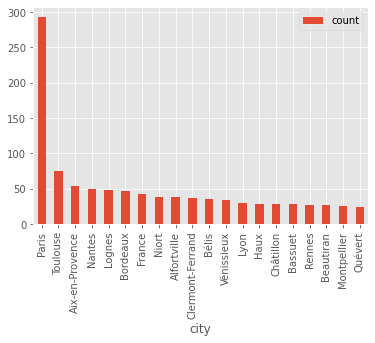

In [22]:
city_ct.iloc[:20,:].plot.bar('city', 'count');

In [23]:
city_ct.iloc[:20]

,city,count
0,Paris,293
1,Toulouse,75
2,Aix-en-Provence,54
3,Nantes,50
4,Lognes,48
5,Bordeaux,47
6,France,42
7,Niort,38
8,Alfortville,38
9,Clermont-Ferrand,37


## How are the replies to the media outlets relating to our candidates?

We want to visualize how the replies to our top two media outlets on our list compare to the replies to our top candidates.

In [40]:
replies_df['tweet_time'] = replies_df['tweet_dt'].apply(lambda x: x.time())
replies_df['tweet_date'] = replies_df['tweet_dt'].apply(lambda x: x.date())

In [66]:
macron = replies_df[replies_df['in_reply_to_screen_name'] == 'EmmanuelMacron']
le_pen = replies_df[replies_df['in_reply_to_screen_name'] == 'MLP_officiel']
tpmp = replies_df[replies_df['in_reply_to_screen_name'] == 'TPMP']
bfmtv = replies_df[replies_df['in_reply_to_screen_name'] == 'BFMTV']

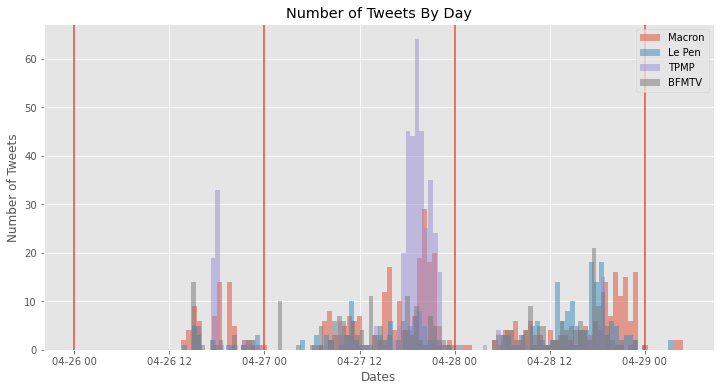

In [68]:
from datetime import datetime
fig, axes = plt.subplots(figsize = (12, 6))
axes.hist(macron['tweet_dt'], bins = 100, alpha = .5, label = 'Macron')
axes.hist(le_pen['tweet_dt'], bins = 100, alpha = .5, label = 'Le Pen')
axes.hist(tpmp['tweet_dt'], bins = 100, alpha = .5, label = 'TPMP')
axes.hist(bfmtv['tweet_dt'], bins = 100, alpha = .5, label = 'BFMTV')
axes.axvline(datetime.strptime('2017-04-26','%Y-%m-%d'), 0, 30)
axes.axvline(datetime.strptime('2017-04-27','%Y-%m-%d'), 0, 30)
axes.axvline(datetime.strptime('2017-04-28','%Y-%m-%d'), 0, 30)
axes.axvline(datetime.strptime('2017-04-29','%Y-%m-%d'), 0, 30)
axes.set_title("Number of Tweets By Day")
axes.set_xlabel("Dates")
axes.set_ylabel("Number of Tweets")
axes.legend();

## Our Conclusions

We are seeing what appears to be trend in viewers of TMPM replying to both TMPM and Macron. We are not seeing much of a trend in replies going to BFMTV relating to an increase in replies to Le Pen. In researching these tv stations we have found that BFMTV is a 24 hour news station and TPMP is a talk show that broadcasts at 830pm. It would seem that TPMP is driving more social media activity, so if the campaign for either party is looking to increase their social media activity then focusing their attention on the TPMP programming could possibly the best strategy. 

## Next Steps

If we were to continue down this path of discovery we would like to find out how many of the replies to either candidate were coming from the same user id. We would also like to try and pinpoint any possible "bots" that are driving a campaign for either candidate. One method for possibly locating these bots is to review user account creation dates and the ratio of followers to following. 